In [2]:
from pyspi.utils.data_builder.time_series_builder import TimeSeriesBuilderSPI
import numpy as np
from pyspi.utils.function_utils import find_response_version
from pyspi.utils.response.spi_response_data import ResponseDataRMF
from pyspi.utils.response.spi_response import ResponseRMFGenerator
from pyspi.utils.response.spi_drm import SPIDRM
from pyspi.utils.livedets import get_live_dets

grb_time = "120711 024453"
ebounds = np.geomspace(20,80,40)
ein = np.geomspace(10,3000,50)
t1 = 35000
t2 = 38000
version = find_response_version(grb_time)
rsp_base = ResponseDataRMF.from_version(version)
dets = get_live_dets(time=grb_time, event_types=["single"])

Using the irfs that are valid between 10/05/27 12:45:00 and present (YY/MM/DD HH:MM:SS)


In [3]:
tsbs = []
sds1 = []
sds2 = []
ra1, dec1 = 94.67830, -70.99905
ra2, dec2 = 92.67830, -70.99905
for d in dets:
    tsb = TimeSeriesBuilderSPI.from_spi_grb(f"SPIDet{d}", 
                                        d, 
                                        #ebounds_sgl, 
                                        grb_time, 
                                        ebounds=ebounds,
                                        sgl_type="both",
                                        poly_order=-1,
                                        )
    rsp = ResponseRMFGenerator.from_time(grb_time,  d,
                                            ebounds, ein,
                                            rsp_base)
    sd1 = SPIDRM(rsp, ra1, dec1)
    sd2 = SPIDRM(rsp.clone(), ra2, dec2)
    tsbs.append(tsb)
    sds1.append(sd1)
    sds2.append(sd2)


WARNING NumbaExperimentalFeatureWarning: Use of isinstance() detected. This is an experimental feature.



In [4]:
bkgs=np.array([])
for tsb in tsbs:
    bkgs = np.append(bkgs, tsb.time_series.count_per_channel_over_interval(-1000,0)/tsb.time_series.exposure_over_interval(-1000,0))
bkgs=bkgs.reshape((len(dets), -1));

In [5]:
# source model
from astromodels import Powerlaw, Log_uniform_prior, Uniform_prior, PointSource, SpectralComponent
import numpy as np
pl = Powerlaw()
pl.index = -2.08
pl.K = 6.44*10**-4
pl.piv = 100

pl.K.prior = Log_uniform_prior(lower_bound=1e-8, upper_bound=1e0)
pl.index.prior = Uniform_prior(lower_bound=-4, upper_bound=0)

component1 = SpectralComponent('pl',shape=pl)
ps = PointSource('plline',ra=94.67830, dec=-70.99905, components=[component1])

spec = ps(ein)

spec_binned = (ein[1:]-ein[:-1])*(spec[:-1]+spec[1:])/2

In [6]:
# model counts
model_count_rates1 = np.array([])#np.dot(spec_binned, sd_sgl1.matrix.T)
model_count_rates2 = np.array([])#np.dot(spec_binned, sd_sgl2.matrix.T)
for sd1, sd2 in zip(sds1, sds2):
    model_count_rates1 = np.append(model_count_rates1, np.dot(spec_binned, sd1.matrix.T))
    model_count_rates2 = np.append(model_count_rates2, np.dot(spec_binned, sd2.matrix.T))
model_count_rates1 = model_count_rates1.reshape((len(dets), -1));
model_count_rates2 = model_count_rates2.reshape((len(dets), -1));

In [7]:
import matplotlib.pyplot as plt
fig, axes = plt.subplots(5,4, sharex=True, sharey=True, figsize=(10,10))
axes = axes.flatten()
i=0
for d in range(19):
    axes[d].text(.5,.9,f"Det {d}",horizontalalignment='center',transform=axes[d].transAxes)
    if d in dets:
        if i==0:
            axes[d].step(ebounds[:-1], bkgs[i], label="background")
            axes[d].step(ebounds[:-1], model_count_rates1[i], label="model1")
            axes[d].step(ebounds[:-1], model_count_rates2[i], label="model2")
        else:
            axes[d].step(ebounds[:-1], bkgs[i])
            axes[d].step(ebounds[:-1], model_count_rates1[i])
            axes[d].step(ebounds[:-1], model_count_rates2[i])
        i+=1
    axes[d].set_yscale("log")
    axes[d].set_ylim(10**-3, 20)
for i in range(16,20):
    axes[i].set_xlabel("Detected Energy [keV]")
for i in range(0,20,4):
    axes[i].set_ylabel("Count Rates [1/s]")
plt.subplots_adjust(hspace=0, wspace=0)
plt.subplots_adjust(hspace=0, top=0.96, bottom=0.1)
lgd = fig.legend(loc='center left', bbox_to_anchor=(0.9, 0.5), fontsize='x-large')
# fig.savefig("bkg_models.pdf")


In [8]:
data1 = np.array([])
data2 = np.array([])
for bkg, m1, m2 in zip(bkgs, model_count_rates1, model_count_rates2):
    data1 = np.append(data1, np.random.poisson(t1*(bkg+m1)))
    data2 = np.append(data2, np.random.poisson(t2*(bkg+m2)))
    
data1 = data1.reshape((len(dets), -1));
data2 = data2.reshape((len(dets), -1));

In [9]:
import math
from numba import njit

@njit
def bmaxba(m1, m2, t1, t2, C1, C2):
    first = C1+C2-(m1+m2)*(t1+t2)
    root = (C1+C2+(m1-m2)*(t1+t2))**2-4*C1*(m1-m2)*(t1+t2)
    res = (first+np.sqrt(root))/(2*(t1+t2))
    return res
matrices1 = np.array([])
sd_x, sd_y = sds1[0].matrix.T.shape
for sd in sds1:
    matrices1=np.append(matrices1,sd.matrix.T)
matrices1=matrices1.reshape((len(dets), sd_x, sd_y))

matrices2 = np.array([])
for sd in sds2:
    matrices2=np.append(matrices2,sd.matrix.T)
matrices2=matrices2.reshape((len(dets), sd_x, sd_y))

@njit
def logLcore(spec_binned):
    logL=0
    for j in range(len(dets)):
        m1 = np.dot(spec_binned, matrices1[j])
        m2 = np.dot(spec_binned, matrices2[j])
        for i in range(len(m1)):
            bm = bmaxba(m1[i], m2[i], t1, t2, data1[j, i], data2[j, i])
            logL += (data1[j,i]*math.log(t1*(m1[i]+bm))+
                    data2[j,i]*math.log(t2*(m2[i]+bm))-
                    t1*(m1[i]+bm)-
                    t2*(m2[i]+bm))
    return logL

def logLba_mult(trial_values, ndim=None, params=None):
    pl.index = trial_values[1]
    pl.K = trial_values[0]
    spec = pl(ein)
    spec_binned = (ein[1:]-ein[:-1])*(spec[:-1]+spec[1:])/2
    return logLcore(spec_binned)

In [10]:
def prior(params, ndim=None, nparams=None):
    for i, (parameter_name, parameter) in enumerate(
        ps.free_parameters.items()
    ):

        try:

            params[i] = parameter.prior.from_unit_cube(params[i])

        except AttributeError:

            raise RuntimeError(
                "The prior you are trying to use for parameter %s is "
                "not compatible with sampling from a unitcube"
                % parameter_name
            )

In [11]:
import pymultinest
import os
if not os.path.exists("./chains"):
    os.mkdir("chains")
sampler = pymultinest.run(
                    logLba_mult, prior, 2, 2, n_live_points=800, resume=False, verbose=True
                )

 *****************************************************
 MultiNest v3.10
 Copyright Farhan Feroz & Mike Hobson
 Release Jul 2015

 no. of live points =  800
 dimensionality =    2
 *****************************************************
 Starting MultiNest
 generating live points
 live points generated, starting sampling
Acceptance Rate:                        0.997653
Replacements:                                850
Total Samples:                               852
Nested Sampling ln(Z):            **************
Importance Nested Sampling ln(Z): ************** +/-  0.999413
Acceptance Rate:                        0.983607
Replacements:                                900
Total Samples:                               915
Nested Sampling ln(Z):            **************
Importance Nested Sampling ln(Z): ************** +/-  0.999453
Acceptance Rate:                        0.977366
Replacements:                                950
Total Samples:                               972
Nested Sampling

In [12]:
%matplotlib inline
from chainconsumer import ChainConsumer
import numpy as np


def loadtxt2d(intext):
        try:
            return np.loadtxt(intext, ndmin=2)
        except:
            return np.loadtxt(intext)

c = ChainConsumer()

chain = loadtxt2d('./chains/1-post_equal_weights.dat')

#c.add_chain(chain, parameters=['K', 'index', 'F', 'mu','sigma', '$z$'], name='yeah')
c.add_chain(chain, parameters=['K', 'index', '$z$'], name='fit')

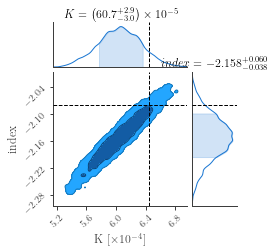

In [13]:
c.plotter.plot(filename="fit_corner.pdf", 
                parameters=['K', 'index'],
                truth=[6.44*10**-4, -2.08],
                log_scales=[]);